# Luminosities from VLASS/GALEX cross-match results and fiducial redshifts

## Import statements

In [29]:
from ident_run_setup import cosmo, load_history, proj_name

from astropy.units import Quantity, spectral_density
from matplotlib import pyplot as plt

import os
import json
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500)

In [2]:
cosmo

LambdaCDM(H0=71.0 km / (Mpc s), Om0=0.2648, Ode0=0.7352, Tcmb0=0.0 K, Neff=3.04, m_nu=None, Ob0=0.0448)

## Setting up directories

In [30]:
lum_out_dir = "outputs/vlass_galex_luminosities/"
os.makedirs(lum_out_dir, exist_ok=True)

## Loading relevant information files

### BCG identification framework history

In [3]:
cur_history = load_history()

### BCG candidate sample

In [4]:
bcg_samp = pd.read_csv("outputs/bcg_output_sample.csv")

# Make some modifications so that the dataframe doesn't distinguish between DESI and LoVoCCS source data ra-decs; I'm 
#  putting the column names as 'ra-BCG{N}' (even though I think it is ugly) because we attempt to use the wide-to-tall
#  pandas method later and it is easier this way around
bcg_samp = bcg_samp.rename(columns={'BCG1_desi-ls_ra': 'ra-BCG1', 'BCG1_desi-ls_dec': 'dec-BCG1', 
                                    'BCG2_desi-ls_ra': 'ra-BCG2', 'BCG2_desi-ls_dec': 'dec-BCG2',
                                    'BCG3_desi-ls_ra': 'ra-BCG3', 'BCG3_desi-ls_dec': 'dec-BCG3',
                                    'BCG4_desi-ls_ra': 'ra-BCG4', 'BCG4_desi-ls_dec': 'dec-BCG4'})

# A399 and A401 have LoVoCCS-photometry defined coords, as they don't appear in the legacy survey. Need to combine
#  the DESI and LoVoCCS columns just into a single column per BCG candidate 
bcg_samp['ra-BCG1'] = np.nanmax(bcg_samp[['ra-BCG1', 'BCG1_lovoccs_ra']].values, axis=1) 
bcg_samp['dec-BCG1'] = np.nanmax(bcg_samp[['dec-BCG1', 'BCG1_lovoccs_dec']].values, axis=1) 
bcg_samp['ra-BCG2'] = np.nanmax(bcg_samp[['ra-BCG2', 'BCG2_lovoccs_ra']].values, axis=1) 
bcg_samp['dec-BCG2'] = np.nanmax(bcg_samp[['dec-BCG2', 'BCG2_lovoccs_dec']].values, axis=1) 

# Getting rid of the now unnecessary LoVoCCS columns
bcg_samp.drop(columns=['BCG1_lovoccs_ra', 'BCG1_lovoccs_dec', 'BCG2_lovoccs_ra', 'BCG2_lovoccs_dec'], inplace=True)
# Also the 'no_bcg_cand' flag column, doesn't matter for this
bcg_samp.drop(columns=['no_bcg_cand'], inplace=True)

bcg_samp.head(15)

/var/folders/td/gw9qkx6d3szb1nkt_cfvcbzm000vzl/T/ipykernel_7774/2768048102.py:15: RuntimeWarning: All-NaN slice encountered
  bcg_samp['ra-BCG2'] = np.nanmax(bcg_samp[['ra-BCG2', 'BCG2_lovoccs_ra']].values, axis=1)
/var/folders/td/gw9qkx6d3szb1nkt_cfvcbzm000vzl/T/ipykernel_7774/2768048102.py:16: RuntimeWarning: All-NaN slice encountered
  bcg_samp['dec-BCG2'] = np.nanmax(bcg_samp[['dec-BCG2', 'BCG2_lovoccs_dec']].values, axis=1)


,cluster_name,ra-BCG1,dec-BCG1,ra-BCG2,dec-BCG2,ra-BCG3,dec-BCG3,ra-BCG4,dec-BCG4
0,LoVoCCS-1,227.733824,5.744883,NaN,NaN,NaN,NaN,NaN,NaN
1,LoVoCCS-2,44.740836,13.582646,NaN,NaN,NaN,NaN,NaN,NaN
2,LoVoCCS-4A,10.460194,-9.302871,NaN,NaN,NaN,NaN,NaN,NaN
3,LoVoCCS-4B,10.429048,-9.439317,NaN,NaN,NaN,NaN,NaN,NaN
4,LoVoCCS-5,303.113338,-56.826500,302.710346,-56.673695,303.50667,-57.027568,303.49407,-57.039226
5,LoVoCCS-7,330.470382,-59.945214,NaN,NaN,NaN,NaN,NaN,NaN
6,LoVoCCS-9,67.802961,-61.453626,67.414206,-61.176134,NaN,NaN,NaN,NaN
7,LoVoCCS-10,194.843512,-4.196002,NaN,NaN,NaN,NaN,NaN,NaN
8,LoVoCCS-11,137.134448,-9.629780,137.329532,-9.698835,NaN,NaN,NaN,NaN
9,LoVoCCS-12,206.867783,-32.864949,NaN,NaN,NaN,NaN,NaN,NaN


### Fiducial BCG candidate spectroscopic redshifts

In [5]:
bcg1_fidz = pd.read_csv("outputs/fiducial_cand_redshift_tables/BCG1_fiducial_specz.csv").rename(columns={'name': 'cluster_name'})
bcg2_fidz = pd.read_csv("outputs/fiducial_cand_redshift_tables/BCG2_fiducial_specz.csv").rename(columns={'name': 'cluster_name'})
bcg3_fidz = pd.read_csv("outputs/fiducial_cand_redshift_tables/BCG3_fiducial_specz.csv").rename(columns={'name': 'cluster_name'})
bcg4_fidz = pd.read_csv("outputs/fiducial_cand_redshift_tables/BCG4_fiducial_specz.csv").rename(columns={'name': 'cluster_name'})

### VLASS QL Ep.1

In [6]:
bcg1_vlass = pd.read_csv("outputs/vlass_galex_crossmatches/bcg1_cands_vlass_searchrad10.0arcsec.csv")
bcg2_vlass = pd.read_csv("outputs/vlass_galex_crossmatches/bcg2_cands_vlass_searchrad10.0arcsec.csv")
bcg3_vlass = pd.read_csv("outputs/vlass_galex_crossmatches/bcg3_cands_vlass_searchrad10.0arcsec.csv")
bcg4_vlass = pd.read_csv("outputs/vlass_galex_crossmatches/bcg4_cands_vlass_searchrad10.0arcsec.csv")

#### How many have multiple matches?

In [7]:
bcg1_vlass_clust_occ = bcg1_vlass.value_counts('cluster_name')
print(bcg1_vlass_clust_occ[bcg1_vlass_clust_occ > 1], '\n')

bcg2_vlass_clust_occ = bcg2_vlass.value_counts('cluster_name')
print(bcg2_vlass_clust_occ[bcg2_vlass_clust_occ > 1], '\n')

bcg3_vlass_clust_occ = bcg3_vlass.value_counts('cluster_name')
print(bcg3_vlass_clust_occ[bcg3_vlass_clust_occ > 1], '\n')

bcg4_vlass_clust_occ = bcg4_vlass.value_counts('cluster_name')
print(bcg4_vlass_clust_occ[bcg4_vlass_clust_occ > 1], '\n')

cluster_name
LoVoCCS-123    5
LoVoCCS-48A    4
LoVoCCS-67     3
LoVoCCS-131    3
LoVoCCS-1      2
LoVoCCS-90     2
LoVoCCS-61     2
LoVoCCS-41C    2
LoVoCCS-99     2
Name: count, dtype: int64 

cluster_name
LoVoCCS-55     2
LoVoCCS-41C    2
Name: count, dtype: int64 

cluster_name
LoVoCCS-28    2
Name: count, dtype: int64 

Series([], Name: count, dtype: int64) 



### GALEX UV Catalog AIS GR6+7

In [8]:
bcg1_galex = pd.read_csv("outputs/vlass_galex_crossmatches/bcg1_cands_galex_searchrad6.0arcsec.csv")
bcg2_galex = pd.read_csv("outputs/vlass_galex_crossmatches/bcg2_cands_galex_searchrad6.0arcsec.csv")
bcg3_galex = pd.read_csv("outputs/vlass_galex_crossmatches/bcg3_cands_galex_searchrad6.0arcsec.csv")
bcg4_galex = pd.read_csv("outputs/vlass_galex_crossmatches/bcg4_cands_galex_searchrad6.0arcsec.csv")

#### How many have multiple matches?

In [9]:
bcg1_galex_clust_occ = bcg1_galex.value_counts('cluster_name')
print(bcg1_galex_clust_occ[bcg1_galex_clust_occ > 1], '\n')

bcg2_galex_clust_occ = bcg2_galex.value_counts('cluster_name')
print(bcg2_galex_clust_occ[bcg2_galex_clust_occ > 1], '\n')

bcg3_galex_clust_occ = bcg3_galex.value_counts('cluster_name')
print(bcg3_galex_clust_occ[bcg3_galex_clust_occ > 1], '\n')

bcg4_galex_clust_occ = bcg4_galex.value_counts('cluster_name')
print(bcg4_galex_clust_occ[bcg4_galex_clust_occ > 1], '\n')

cluster_name
LoVoCCS-21     2
LoVoCCS-134    2
Name: count, dtype: int64 

cluster_name
LoVoCCS-134    2
Name: count, dtype: int64 

Series([], Name: count, dtype: int64) 

Series([], Name: count, dtype: int64) 



## Combining information

Rather than one giga-table, we will make tables for each set of BCG candidates (i.e. BCG1, BCG2, ...) - this will be easier because some of the cross-matches have multiple entries per BCG candidate - due to the fact that it wasn't really a cross-match, it was a cone-search within a search radius.

In [10]:
fidz_cols = ['cluster_name', 'z']

### VLASS

We won't be merging GALEX and VLASS matches together, because as they both may have multiple possible matches to the BCG candidate, they are not necessarily representing the same thing - the VLASS matches may be representing different components of large jets for instance (can be registered as multiple entries in the VLASS catalogs), whereas the GALEX matches will hopefully just be the galaxy itself:

In [11]:
vlass_cols = ['cluster_name', 'Ftot', 'e_Ftot', 'Fpeak', 'e_Fpeak', 'arcsec_sep_from_bcg']

Combining tables:

In [12]:
bcg1_vlass_info = pd.merge(bcg1_vlass[vlass_cols], bcg1_fidz[fidz_cols], on='cluster_name')
bcg2_vlass_info = pd.merge(bcg2_vlass[vlass_cols], bcg2_fidz[fidz_cols], on='cluster_name')
bcg3_vlass_info = pd.merge(bcg3_vlass[vlass_cols], bcg3_fidz[fidz_cols], on='cluster_name')

# No VLASS matches here
# bcg4_vlass_info = pd.merge(bcg4_vlass[vlass_cols], bcg4_fidz[fidz_cols], on='cluster_name')

bcg1_vlass_info = bcg1_vlass_info.dropna(subset=['Ftot'], how='all')
bcg2_vlass_info = bcg2_vlass_info.dropna(subset=['Ftot'], how='all')
bcg3_vlass_info = bcg3_vlass_info.dropna(subset=['Ftot'], how='all')
# bcg4_vlass_info = bcg4_vlass_info.dropna(subset=['Ftot'], how='all')

### GALEX

In [13]:
galex_cols = ['cluster_name', 'b', 'E(B-V)', 'Fflux', 'e_Fflux', 'Nflux', 'e_Nflux', 'arcsec_sep_from_bcg']
galex_rename_cols = {'b': 'bands', 'Fflux': 'FUV_flux', 'e_Fflux': 'err_FUV_flux', 
                     'Nflux': 'NUV_flux', 'e_Nflux': 'err_NUV_flux'}
galex_conv_col_vals = {'bands': {1: 'NUV', 2: 'FUV', 3: 'NUV+FUV'}}

Combining tables:

In [14]:
bcg1_galex_info = pd.merge(bcg1_galex[galex_cols], bcg1_fidz[fidz_cols], on='cluster_name').rename(columns=galex_rename_cols)
bcg2_galex_info = pd.merge(bcg2_galex[galex_cols], bcg2_fidz[fidz_cols], on='cluster_name').rename(columns=galex_rename_cols)
bcg3_galex_info = pd.merge(bcg3_galex[galex_cols], bcg3_fidz[fidz_cols], on='cluster_name').rename(columns=galex_rename_cols)
bcg4_galex_info = pd.merge(bcg4_galex[galex_cols], bcg4_fidz[fidz_cols], on='cluster_name').rename(columns=galex_rename_cols)

for col_to_conv, conv_dict in galex_conv_col_vals.items():
    bcg1_galex_info[col_to_conv] = bcg1_galex_info[col_to_conv].apply(lambda x: conv_dict[x] if not np.isnan(x) else x)
    bcg2_galex_info[col_to_conv] = bcg2_galex_info[col_to_conv].apply(lambda x: conv_dict[x] if not np.isnan(x) else x)
    bcg3_galex_info[col_to_conv] = bcg3_galex_info[col_to_conv].apply(lambda x: conv_dict[x] if not np.isnan(x) else x)
    bcg4_galex_info[col_to_conv] = bcg4_galex_info[col_to_conv].apply(lambda x: conv_dict[x] if not np.isnan(x) else x)

bcg1_galex_info = bcg1_galex_info.dropna(subset=['NUV_flux', 'FUV_flux'], how='all')
bcg2_galex_info = bcg2_galex_info.dropna(subset=['NUV_flux', 'FUV_flux'], how='all')
bcg3_galex_info = bcg3_galex_info.dropna(subset=['NUV_flux', 'FUV_flux'], how='all')
bcg4_galex_info = bcg4_galex_info.dropna(subset=['NUV_flux', 'FUV_flux'], how='all')

## Calculating luminosities

### VLASS

<span style='color:red'>**THE FLUX DENSITIES IN THIS CATALOG ARE THOUGHT TO BE SYSTEMATICALLY UNDERESTIMATED BY ~15%**</span>

The effective frequency I have chosen is simply because it is the middle of the S-band that the VLASS observations are made in:

In [15]:
VLASS_EFF_FREQ = Quantity(3, 'GHz')

Calculating the luminosities:

In [33]:
for cur_cand_ind, cur_cand_info in enumerate([bcg1_vlass_info, bcg2_vlass_info, bcg2_vlass_info, bcg2_vlass_info]):
    # Calculating luminosity distance
    cur_lum_dist = cosmo.luminosity_distance(cur_cand_info['z'].values)[..., None]
    # Reading out total VLASS flux/err
    cur_vlass_flux = Quantity(cur_cand_info[['Ftot', 'e_Ftot']].values, '1e-6 Jy')
    
    # Now the actual calculation
    cur_vlass_lum = (4*np.pi*(cur_lum_dist**2)*cur_vlass_flux).to('erg/s', equivalencies=spectral_density(VLASS_EFF_FREQ))
    cur_cand_info[['VLASS_lum', 'err_VLASS_lum']] = cur_vlass_lum.value

    cur_cand_info.to_csv(lum_out_dir + "BCG" + str(cur_cand_ind+1) + "_vlass_luminosities" + ".csv", index=False)

### GALEX

Have to use an effective wavelength to go from luminosity spectral density to luminosity - these are for GALEX, and are taken from https://ui.adsabs.harvard.edu/abs/2007ApJS..173..682M/abstract.

In [17]:
FUV_EFF_WAV = Quantity(1538.6, 'angstrom')
NUV_EFF_WAV = Quantity(2315.7, 'angstrom')

Calculating the luminosities:

In [34]:
for cur_cand_ind, cur_cand_info in enumerate([bcg1_galex_info, bcg2_galex_info, bcg2_galex_info, bcg2_galex_info]):
    # Calculating luminosity distance
    cur_lum_dist = cosmo.luminosity_distance(cur_cand_info['z'].values)[..., None]
    # Reading out FUV flux/err
    cur_fuv_flux = Quantity(cur_cand_info[['FUV_flux', 'err_FUV_flux']].values, '1e-6 Jy')
    # Same for NUV
    cur_nuv_flux = Quantity(cur_cand_info[['NUV_flux', 'err_NUV_flux']].values, '1e-6 Jy')

    # Now the actual calculation
    cur_fuv_lum = (4*np.pi*(cur_lum_dist**2)*cur_fuv_flux).to('erg/s', equivalencies=spectral_density(FUV_EFF_WAV))
    cur_cand_info[['FUV_lum', 'err_FUV_lum']] = cur_fuv_lum.value
    
    cur_nuv_lum = (4*np.pi*(cur_lum_dist**2)*cur_nuv_flux).to('erg/s', equivalencies=spectral_density(NUV_EFF_WAV))
    cur_cand_info[['NUV_lum', 'err_NUV_lum']] = cur_nuv_lum.value

    cur_cand_info.to_csv(lum_out_dir + "BCG" + str(cur_cand_ind+1) + "_galex_luminosities" + ".csv", index=False)

## Comparing VLASS and GALEX luminosities

### BCG1 - selecting matches closest to the BCG candidate

Here we wish to plot the VLASS and GALEX luminosities against one another - some cluster BCG candidates have multiple matches in VLASS or GALEX catalogs, and in those cases we will choose just one entry to compare. The entry selected will be the one closest to the original BCG candidate coordinate.

In [19]:
bcg1_vlass_info = bcg1_vlass_info.reset_index(drop=True)
sel_ind = bcg1_vlass_info.groupby('cluster_name').idxmin()['arcsec_sep_from_bcg']  #[bcg1_vlass_info['cluster_name']]
# 
bcg1_single_match_vlass_lums = bcg1_vlass_info.loc[sel_ind, ['cluster_name', 'VLASS_lum', 'err_VLASS_lum']]

In [20]:
bcg1_galex_info = bcg1_galex_info.reset_index(drop=True)
sel_ind = bcg1_galex_info.groupby('cluster_name').idxmin()['arcsec_sep_from_bcg']  #[bcg1_galex_info['cluster_name']]
# 
bcg1_single_match_galex_lums = bcg1_galex_info.loc[sel_ind, ['cluster_name', 'FUV_lum', 'err_FUV_lum', 'NUV_lum', 'err_NUV_lum']]

Combining the tables:

In [21]:
bcg1_onematch_vlass_galex_lums = pd.merge(bcg1_single_match_vlass_lums, bcg1_single_match_galex_lums, on='cluster_name')

Viewing the relation between UV and VLASS luminosity:

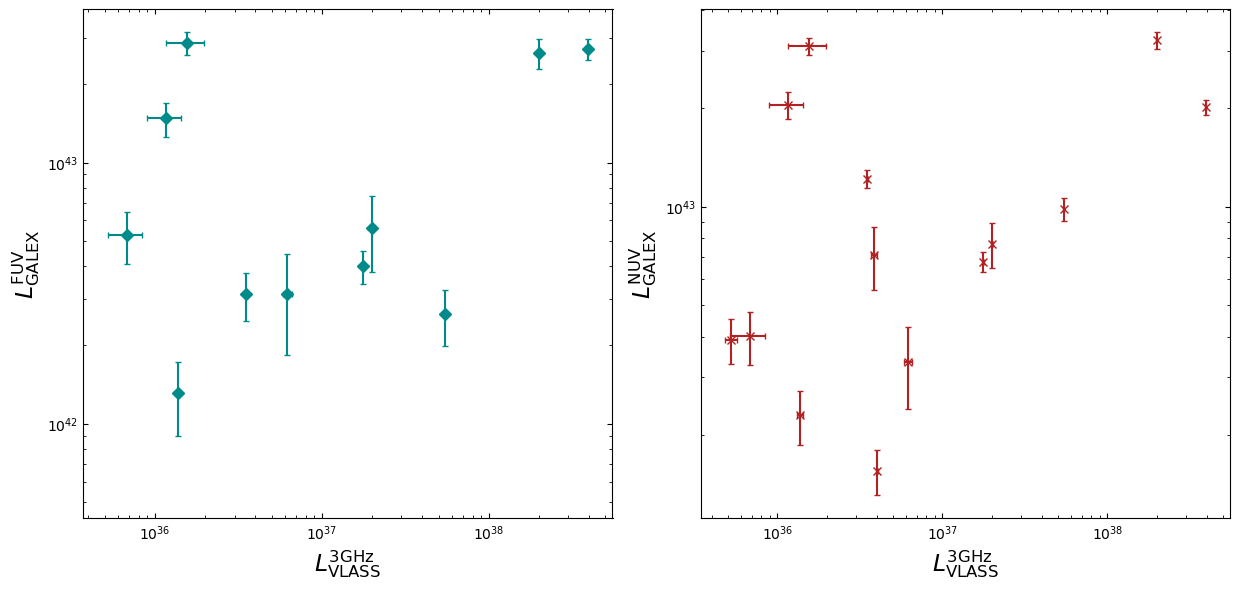

In [35]:
fig, ax_arr = plt.subplots(ncols=2, figsize=(12.5, 6))

for ax in ax_arr:
    ax.minorticks_on()
    ax.tick_params(which='both', direction='in', top=True, right=True)

ax = ax_arr[0]
# Plotting the FUV data
ax.errorbar(bcg1_onematch_vlass_galex_lums['VLASS_lum'].values, bcg1_onematch_vlass_galex_lums['FUV_lum'].values,
            xerr=bcg1_onematch_vlass_galex_lums['err_VLASS_lum'].values, yerr=bcg1_onematch_vlass_galex_lums['err_FUV_lum'].values, 
            fmt='D', capsize=2, color='darkcyan')

# Labelling
ax.set_xlabel(r'$L^{3\rm{GHz}}_{\rm{VLASS}}$', fontsize=17)
ax.set_ylabel(r'$L^{\rm{FUV}}_{\rm{GALEX}}$', fontsize=17)

# Log scaling yay
ax.set_xscale('log')
ax.set_yscale('log')

ax = ax_arr[1]
# Plotting the FUV data
ax.errorbar(bcg1_onematch_vlass_galex_lums['VLASS_lum'].values, bcg1_onematch_vlass_galex_lums['NUV_lum'].values,
            xerr=bcg1_onematch_vlass_galex_lums['err_VLASS_lum'].values, yerr=bcg1_onematch_vlass_galex_lums['err_NUV_lum'].values, 
            fmt='x', capsize=2, color='firebrick')

# Labelling
ax.set_xlabel(r'$L^{3\rm{GHz}}_{\rm{VLASS}}$', fontsize=17)
ax.set_ylabel(r'$L^{\rm{NUV}}_{\rm{GALEX}}$', fontsize=17)

# Log scaling yay
ax.set_xscale('log')
ax.set_yscale('log')

# plt.legend(loc='best')

plt.tight_layout()
plt.savefig(lum_out_dir + "BCG1_uvlum-vs-vlasslum.pdf")
plt.show()

In [23]:
bcg1_onematch_vlass_galex_lums[(bcg1_onematch_vlass_galex_lums['VLASS_lum'] < 3e+36) & (bcg1_onematch_vlass_galex_lums['FUV_lum'] > 4e+42)]

,cluster_name,VLASS_lum,err_VLASS_lum,FUV_lum,err_FUV_lum,NUV_lum,err_NUV_lum
1,LoVoCCS-119,1.566077e+36,4.026790e+35,2.868025e+43,2.904961e+42,3.099745e+43,1.951002e+42
12,LoVoCCS-75,1.162527e+36,2.667028e+35,1.475145e+43,2.220860e+42,2.048046e+43,1.886228e+42
14,LoVoCCS-98,6.789770e+35,1.583557e+35,5.284385e+42,1.205281e+42,4.004519e+42,7.412979e+41


### BCG2 - selecting matches closest to the BCG candidate

In [24]:
bcg2_vlass_info = bcg2_vlass_info.reset_index(drop=True)
sel_ind = bcg2_vlass_info.groupby('cluster_name').idxmin()['arcsec_sep_from_bcg']  #[bcg1_vlass_info['cluster_name']]
# 
bcg2_single_match_vlass_lums = bcg2_vlass_info.loc[sel_ind, ['cluster_name', 'VLASS_lum', 'err_VLASS_lum']]

In [25]:
bcg2_galex_info = bcg2_galex_info.reset_index(drop=True)
sel_ind = bcg2_galex_info.groupby('cluster_name').idxmin()['arcsec_sep_from_bcg']  #[bcg1_galex_info['cluster_name']]
# 
bcg2_single_match_galex_lums = bcg2_galex_info.loc[sel_ind, ['cluster_name', 'FUV_lum', 'err_FUV_lum', 'NUV_lum', 'err_NUV_lum']]

Combining the tables:

In [26]:
bcg2_onematch_vlass_galex_lums = pd.merge(bcg2_single_match_vlass_lums, bcg2_single_match_galex_lums, on='cluster_name')

Viewing the relation between UV and VLASS luminosity:

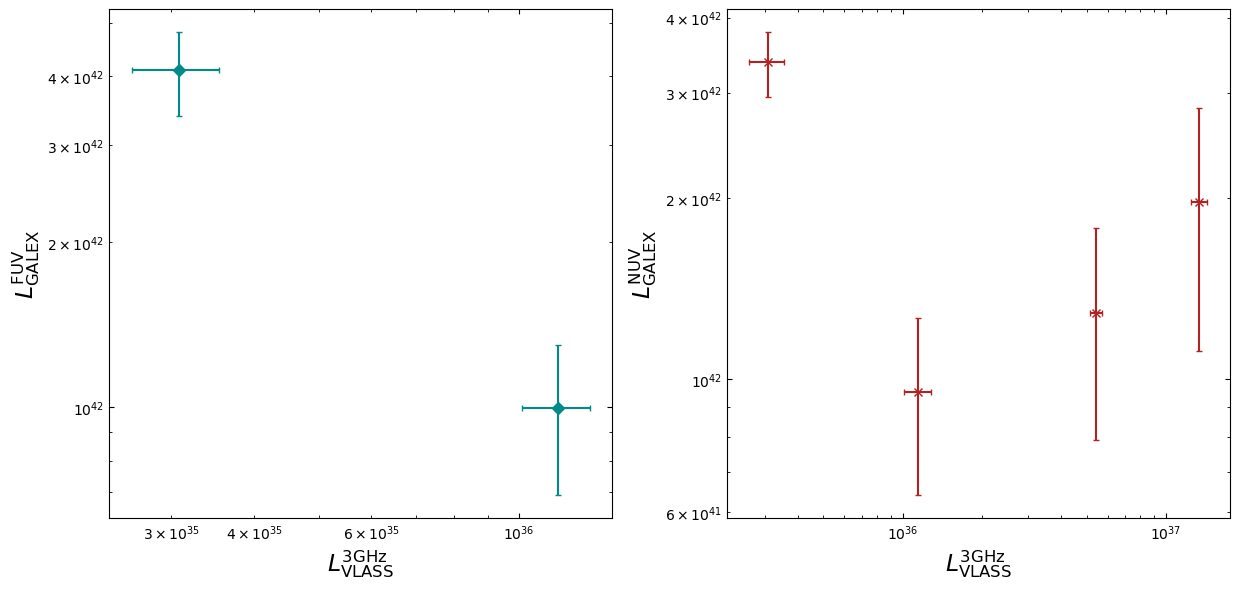

In [36]:
fig, ax_arr = plt.subplots(ncols=2, figsize=(12.5, 6))

for ax in ax_arr:
    ax.minorticks_on()
    ax.tick_params(which='both', direction='in', top=True, right=True)

ax = ax_arr[0]
# Plotting the FUV data
ax.errorbar(bcg2_onematch_vlass_galex_lums['VLASS_lum'].values, bcg2_onematch_vlass_galex_lums['FUV_lum'].values,
            xerr=bcg2_onematch_vlass_galex_lums['err_VLASS_lum'].values, yerr=bcg2_onematch_vlass_galex_lums['err_FUV_lum'].values, 
            fmt='D', capsize=2, color='darkcyan')

# Labelling
ax.set_xlabel(r'$L^{3\rm{GHz}}_{\rm{VLASS}}$', fontsize=17)
ax.set_ylabel(r'$L^{\rm{FUV}}_{\rm{GALEX}}$', fontsize=17)

# Log scaling yay
ax.set_xscale('log')
ax.set_yscale('log')

ax = ax_arr[1]
# Plotting the FUV data
ax.errorbar(bcg2_onematch_vlass_galex_lums['VLASS_lum'].values, bcg2_onematch_vlass_galex_lums['NUV_lum'].values,
            xerr=bcg2_onematch_vlass_galex_lums['err_VLASS_lum'].values, yerr=bcg2_onematch_vlass_galex_lums['err_NUV_lum'].values, 
            fmt='x', capsize=2, color='firebrick')

# Labelling
ax.set_xlabel(r'$L^{3\rm{GHz}}_{\rm{VLASS}}$', fontsize=17)
ax.set_ylabel(r'$L^{\rm{NUV}}_{\rm{GALEX}}$', fontsize=17)

# Log scaling yay
ax.set_xscale('log')
ax.set_yscale('log')

# plt.legend(loc='best')

plt.savefig(lum_out_dir + "BCG2_uvlum-vs-vlasslum.pdf")
plt.tight_layout()
plt.show()